In [1]:
import matplotlib
import operator
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 10

# import custom functions
from functions_statistical_performance import *

SyntaxError: invalid syntax (_metadata_requests.py, line 1512)

In [3]:
# True to exactly reproduce the results presented in the paper (same classifiers)
reproduceflag=False

In [4]:
# function to predict over a generic db when you already have the classifiers
# it provides the average FPro 
def ClassifyDB(db, model_per_fold,nut_sel):
    dbsel=db.loc[:,nut_sel]
    Xnut=dbsel.values    
    
    indfold=0
    for model in model_per_fold:
        indfold+=1
        y_pred = model.predict(Xnut)
        y_probs= model.predict_proba(Xnut)
        db['classf'+str(indfold)]=y_pred
        db['p1f'+str(indfold)]=y_probs[:,0]
        db['p2f'+str(indfold)]=y_probs[:,1]
        db['p3f'+str(indfold)]=y_probs[:,2]
        db['p4f'+str(indfold)]=y_probs[:,3]
        db['FProf'+str(indfold)]=(1-db['p1f'+str(indfold)]+db['p4f'+str(indfold)])/2
     
    for p in range(1,5):
        db['p'+str(p)]=db.loc[:, ['p'+str(p)+'f1', 'p'+str(p)+'f2', 'p'+str(p)+'f3','p'+str(p)+'f4', 'p'+str(p)+'f5' ]].mean(axis=1)
        db['std_p'+str(p)]=db.loc[:, ['p'+str(p)+'f1', 'p'+str(p)+'f2', 'p'+str(p)+'f3','p'+str(p)+'f4', 'p'+str(p)+'f5' ]].std(axis=1)


    db['FPro']=db.loc[:, ['FProf1', 'FProf2', 'FProf3','FProf4', 'FProf5' ]].mean(axis=1)
    db['std_FPro']=db.loc[:, ['FProf1', 'FProf2', 'FProf3','FProf4', 'FProf5']].std(axis=1)
    db['min_FPro']=db.loc[:, ['FProf1', 'FProf2', 'FProf3','FProf4', 'FProf5']].min(axis=1)


    db['max_p']=db.loc[:, ['p1', 'p2', 'p3','p4' ]].idxmax(axis=1)
    db['class']=[int(s[1])-1 for s in db.loc[:, ['p1', 'p2', 'p3','p4' ]].idxmax(axis=1)]
    db['min_in_which_fold']=db.loc[:, ['FProf1', 'FProf2', 'FProf3','FProf4', 'FProf5']].idxmin(axis=1)
    db['min_fold_id']=[int(s[-1]) for s in db.loc[:, ['FProf1', 'FProf2', 'FProf3','FProf4', 'FProf5']].idxmin(axis=1)]
    db['min_class']=[db['classf'+str(db['min_fold_id'].iloc[n])].iloc[n] for n in range(db.shape[0])]
    
    for ind in range(1,5):
        db['p'+str(ind)+'_minFPro']=[db['p'+str(ind)+'f'+str(db['min_fold_id'].iloc[n])].iloc[n] for n in range(db.shape[0])]
    

    return db

# Load 2009-2010 Data

In [5]:
# log-transformed nutrient content per 100 grams
RFFNDDS=pd.read_csv('./input_data/FNDDS_2009-10_Training_Data.csv')
RFFNDDS

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,Total flavones,Total flavonols,Total isoflavones,Food_code,Main_food_description,catnumb,catname,novaclass,macroclass,pythonlabel
0,-20.000000,-20.000000,-20.000000,-20.0,-1.609438,-20.0,-20.0,-20.000000,-20.0,-3.729701,...,-20.0,-20.0,-20.0,2047,"Salt, table",0,addition1516,2,Other,1
1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,...,-20.0,-20.0,-20.0,11000000,"Milk, human",9602,Human milk,1,Milk,0
2,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,...,-20.0,-20.0,-20.0,11100000,"Milk, NFS",1004,"Milk, reduced fat",1,Milk,0
3,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,...,-20.0,-20.0,-20.0,11111000,"Milk, cow's, fluid, whole",1002,"Milk, whole",1,Milk,0
4,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,...,-20.0,-20.0,-20.0,11111100,"Milk, cow's, fluid, whole, low-sodium",1002,"Milk, whole",1,Milk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94100200,"Water, bottled, sweetened, with low or no calo...",7802,Flavored or carbonated water,4,Other,3
7250,-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94100300,"Water, fruit flavored, sweetened, with high fr...",7802,Flavored or carbonated water,4,Other,3
7251,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94210100,Propel Water,7804,Enhanced or fortified water,4,Other,3
7252,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94210200,Glaceau Water,7804,Enhanced or fortified water,4,Other,3


In [7]:
# total nutrient list
nl=list(RFFNDDS.columns)
nl=nl[0:-7]
len(nl)

99

# Whole Nutrient Panel Analysis

In [12]:
if reproduceflag:
    model_per_foldWNP=joblib.load("./paper_classifiers_outcomes/FNDDS0910_99Nutrients_5folds_SMOTE.pkl")
else:
    data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
    X=data2train.loc[:, 'Protein': 'Total isoflavones']
    data2train_dedup = data2train.drop_duplicates([a for a in X.columns] + ['pythonlabel'])
    X_dedup = data2train_dedup.loc[:, 'Protein': 'Total isoflavones']
    y=data2train['pythonlabel']
    y_dedup=data2train_dedup['pythonlabel']
    smoteflag=True
    # Now run the function four times with different SMOTE settings
    smote_modes = ['none', 'train', 'train_test', 'before_split']
    for mode in smote_modes:
        print(f"\n===== Results for SMOTE mode: {mode} =====")
        AUCAUPkfold_full(X_dedup, y_dedup, smote_mode=mode)


===== Results for SMOTE mode: none =====
full3

AUC: average over the folds
[0.96741024 0.9763556  0.95737618 0.97109582]
AUC: std over the folds
[0.01129059 0.01437157 0.00544158 0.00741366]

AUP: average over the folds
[0.82706029 0.68518744 0.82954144 0.98741969]
AUP: std over the folds
[0.05501133 0.10719542 0.01616246 0.00363709]

Balanced Accuracy: average over the folds
0.721399178883303
Balanced Accuracy: std over the folds
0.023238320039974603

Top 10 important features:
Sodium: 0.0480
Carbohydrate: 0.0475
Protein: 0.0405
Total Fat: 0.0358
Water: 0.0342
Fatty acids, total saturated: 0.0295
18:01: 0.0281
Fatty acids, total monounsaturated: 0.0281
Potassium: 0.0278
Sugars, total: 0.0253

===== Results for SMOTE mode: train =====
full3

AUC: average over the folds
[0.97367676 0.98054907 0.9620415  0.97430407]
AUC: std over the folds
[0.00922957 0.0131944  0.00333428 0.00644657]

AUP: average over the folds
[0.84473732 0.71820643 0.84910474 0.9894418 ]
AUP: std over the folds
[0.

In [34]:
# Duplicated samples
data2train[data2train.duplicated([a for a in X.columns] + ['pythonlabel'], False)].sort_values([a for a in X.columns])

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,Total flavones,Total flavonols,Total isoflavones,Food_code,Main_food_description,catnumb,catname,novaclass,macroclass,pythonlabel
7246,-20.000000,-20.000000,-20.000000,-20.000000,4.604170,-20.0,-20.0,-20.0,-20.0,-5.809143,...,-20.0,-20.0,-20.0,94000000,Water as an ingredient,7702,Tap water,1,Other,0
7247,-20.000000,-20.000000,-20.000000,-20.000000,4.604170,-20.0,-20.0,-20.0,-20.0,-5.809143,...,-20.0,-20.0,-20.0,94000100,"Water, tap",7702,Tap water,1,Other,0
7248,-20.000000,-20.000000,-20.000000,-20.000000,4.604970,-20.0,-20.0,-20.0,-20.0,-4.605170,...,-20.0,-20.0,-20.0,94100100,"Water, bottled, unsweetened",7704,Bottled water,1,Other,0
7253,-20.000000,-20.000000,-20.000000,-20.000000,4.604970,-20.0,-20.0,-20.0,-20.0,-4.605170,...,-20.0,-20.0,-20.0,94300100,"Water, baby, bottled, unsweetened",9204,Baby water,1,Other,0
7240,-20.000000,-20.000000,-20.000000,3.508556,4.198705,-20.0,-20.0,-20.0,-20.0,-20.000000,...,-20.0,-20.0,-20.0,93501000,Brandy,7506,Liquor and cocktails,4,Other,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,3.611998,3.732418,0.357674,-20.000000,2.511224,-20.0,-20.0,-20.0,-20.0,-4.509860,...,-20.0,-20.0,-20.0,22601000,"Pork bacon, smoked or cured, cooked",2604,Bacon,3,Other,2
784,3.611998,3.732418,0.357674,-20.000000,2.511224,-20.0,-20.0,-20.0,-20.0,-4.509860,...,-20.0,-20.0,-20.0,22601040,"Bacon or side pork, fresh, cooked",2604,Bacon,3,Other,2
795,3.611998,3.732418,0.357674,-20.000000,2.511224,-20.0,-20.0,-20.0,-20.0,-4.509860,...,-20.0,-20.0,-20.0,22704010,"Pork, cracklings, cooked",2006,Pork,3,Meat,2
1207,4.140273,0.862890,-20.000000,-20.000000,2.781301,-20.0,-20.0,-20.0,-20.0,-1.832581,...,-20.0,-20.0,-20.0,26100170,"Fish, NS as to type, dried",2402,Fish,3,Fish,2


In [37]:
# Duplicated count
len(data2train[data2train.duplicated([a for a in X.columns] + ['pythonlabel'],False)]) / len(data2train)

0.22248401211713228

<AxesSubplot:>

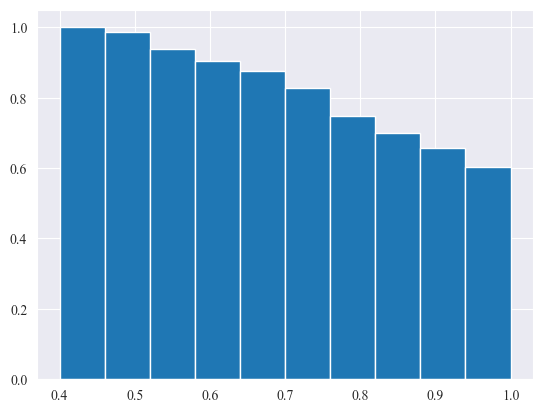

In [32]:
# This is how many of the inner categories are the same as the most dominant label.
data2train.groupby('catnumb')['pythonlabel'].apply(lambda x: (x==x.mode()[0]).mean()).hist(cumulative=-1,density=True)

In [44]:
len(data2train['catnumb'].unique())

146

In [45]:
RFFNDDS

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,Total flavones,Total flavonols,Total isoflavones,Food_code,Main_food_description,catnumb,catname,novaclass,macroclass,pythonlabel
0,-20.000000,-20.000000,-20.000000,-20.0,-1.609438,-20.0,-20.0,-20.000000,-20.0,-3.729701,...,-20.0,-20.0,-20.0,2047,"Salt, table",0,addition1516,2,Other,1
1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,...,-20.0,-20.0,-20.0,11000000,"Milk, human",9602,Human milk,1,Milk,0
2,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,...,-20.0,-20.0,-20.0,11100000,"Milk, NFS",1004,"Milk, reduced fat",1,Milk,0
3,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,...,-20.0,-20.0,-20.0,11111000,"Milk, cow's, fluid, whole",1002,"Milk, whole",1,Milk,0
4,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,...,-20.0,-20.0,-20.0,11111100,"Milk, cow's, fluid, whole, low-sodium",1002,"Milk, whole",1,Milk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94100200,"Water, bottled, sweetened, with low or no calo...",7802,Flavored or carbonated water,4,Other,3
7250,-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94100300,"Water, fruit flavored, sweetened, with high fr...",7802,Flavored or carbonated water,4,Other,3
7251,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94210100,Propel Water,7804,Enhanced or fortified water,4,Other,3
7252,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94210200,Glaceau Water,7804,Enhanced or fortified water,4,Other,3


In [46]:
RFFNDDS['cat_untagged_perc'] = RFFNDDS['catnumb'].map((RFFNDDS.groupby('catnumb')['pythonlabel'].apply(lambda x: (x==-1).mean())).to_dict())

In [54]:
(RFFNDDS[RFFNDDS['pythonlabel']==-1]['cat_untagged_perc']>0.8).mean()

0.7030119075414429

In [56]:
RFFNDDS['catnumb'].value_counts()

3002    315
3802    287
5502    285
6420    283
2402    183
       ... 
7702      2
7704      1
0         1
9602      1
9204      1
Name: catnumb, Length: 151, dtype: int64

In [8]:
# summary database
df=RFFNDDS.copy()
df=ClassifyDB(df,model_per_foldWNP, nl)
df.to_csv('./output_data/FNDDS_2009-10_99_Nutrients_ensemble_5folds.csv')
df

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,min_FPro,max_p,class,min_in_which_fold,min_fold_id,min_class,p1_minFPro,p2_minFPro,p3_minFPro,p4_minFPro
0,-20.000000,-20.000000,-20.000000,-20.0,-1.609438,-20.0,-20.0,-20.000000,-20.0,-3.729701,...,0.5200,p2,1,FProf2,2,1,0.010,0.925,0.015,0.050
1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,...,0.1675,p1,0,FProf5,5,0,0.800,0.020,0.045,0.135
2,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,...,0.0000,p1,0,FProf2,2,0,1.000,0.000,0.000,0.000
3,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,...,0.0000,p1,0,FProf1,1,0,1.000,0.000,0.000,0.000
4,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,...,0.0325,p1,0,FProf1,1,0,0.955,0.010,0.015,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,-20.0,-6.907755,...,0.5000,p4,3,FProf1,1,0,0.410,0.180,0.000,0.410
7250,-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,-20.0,-4.074542,...,0.9300,p4,3,FProf4,4,3,0.040,0.040,0.020,0.900
7251,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,-20.0,-6.907755,...,0.9625,p4,3,FProf3,3,3,0.015,0.020,0.025,0.940
7252,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,-20.0,-4.074542,...,0.8400,p4,3,FProf4,4,3,0.100,0.085,0.035,0.780


# Standard Release FNDDS (for releases without flavonoids)

In [9]:
RFFNDDSSR=RFFNDDS.loc[:, 'Protein': 'Fatty acids, total polyunsaturated']
StandardNutPanel=list(RFFNDDSSR.columns)
RFFNDDSSR['pythonlabel']=RFFNDDS['pythonlabel'].copy()
print('Number of Nutrients in the Standard Nutrient Panel')
print(len(StandardNutPanel))

Number of Nutrients in the Standard Nutrient Panel
62


In [10]:
if reproduceflag:
    model_per_fold62nut=joblib.load("./paper_classifiers_outcomes/FNDDS0910_62Nutrients_5folds_SMOTE.pkl")
else:
    data2train=RFFNDDSSR[RFFNDDSSR.pythonlabel!=-1]
    data2train['pythonlabel'] = np.random.permutation(data2train['pythonlabel'].values)
    X=data2train.loc[:, 'Protein': 'Fatty acids, total polyunsaturated']
    y=data2train['pythonlabel']
    smoteflag=True
    (performancesAUC62nut, performancesAUP62nut, splits62nut, model_per_fold62nut)=AUCAUPkfold(X,y,smoteflag)

C:\Users\harel\PycharmProjects\MLFoodProcessing-auto\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


AUC: average over the folds
[0.97108489 0.99717026 0.95215905 0.91953341]
AUC: std over the folds
[0.00483395 0.00137033 0.00768767 0.00725922]
AUP: average over the folds
[0.91169597 0.99394666 0.85793421 0.76179953]
AUP: std over the folds
[0.01923205 0.0022536  0.01319232 0.02920888]
Balanced Accuracy: average over the folds
0.8615080165372593
Balanced Accuracy: std over the folds
0.014935306019727503


In [11]:
# summary database
df=RFFNDDSSR.copy()
df=ClassifyDB(df,model_per_fold62nut,StandardNutPanel)
df.to_csv('./output_data/FNDDS_2009-10_62Nutrients_ensemble_5folds.csv')
df

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,min_FPro,max_p,class,min_in_which_fold,min_fold_id,min_class,p1_minFPro,p2_minFPro,p3_minFPro,p4_minFPro
0,-20.000000,-20.000000,-20.000000,-20.0,-1.609438,-20.0,-20.0,-20.000000,-20.0,-3.729701,...,0.617250,p4,3,FProf2,2,2,0.120000,0.113750,0.411750,0.354500
1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,...,0.531250,p4,3,FProf5,5,3,0.253750,0.255417,0.174583,0.316250
2,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,...,0.662083,p4,3,FProf4,4,3,0.256667,0.010000,0.152500,0.580833
3,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,...,0.958750,p4,3,FProf3,3,3,0.035000,0.000000,0.012500,0.952500
4,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,...,0.598021,p4,3,FProf4,4,3,0.334167,0.020000,0.115625,0.530208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,-20.0,-6.907755,...,0.502500,p3,2,FProf5,5,2,0.015000,0.005000,0.960000,0.020000
7250,-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,-20.0,-4.074542,...,0.845000,p4,3,FProf3,3,3,0.045000,0.065000,0.155000,0.735000
7251,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,-20.0,-6.907755,...,0.520000,p3,2,FProf2,2,2,0.025000,0.005000,0.905000,0.065000
7252,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,-20.0,-4.074542,...,0.870833,p4,3,FProf4,4,3,0.032500,0.075000,0.118333,0.774167


# Classify FNDDS 2015-2016 with 62 Nutrients

In [12]:
# log-transformed nutrient content per 100 grams
RFFNDDS20152016=pd.read_csv('./input_data/FNDDS_2015-16.csv')
df=ClassifyDB(RFFNDDS20152016,model_per_fold62nut,StandardNutPanel)
df.to_csv("./output_data/FNDDS_2015-16_62Nutrients_ensemble_5folds.csv")
df

C:\Users\harel\PycharmProjects\MLFoodProcessing-auto\venv\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Food code,Main food description,year,cat_digit_1,cat_digit_2,cat_digit_3,cat_digit_4,cat_digit_5,WWEIA Category number,WWEIA Category description,...,min_FPro,max_p,class,min_in_which_fold,min_fold_id,min_class,p1_minFPro,p2_minFPro,p3_minFPro,p4_minFPro
0,11000000,"Milk, human",2015,Milk and Milk Products,Milks and milk drinks,"Milk, human",NaN,NaN,9602,Human milk,...,0.531250,p4,3,FProf5,5,3,0.253750,0.255417,0.174583,0.316250
1,11100000,"Milk, NFS",2015,Milk and Milk Products,Milks and milk drinks,"Milk, fluid (regular; filled; buttermilk; and ...",NaN,NaN,1004,"Milk, reduced fat",...,0.657083,p4,3,FProf4,4,3,0.261667,0.010000,0.152500,0.575833
2,11111000,"Milk, whole",2015,Milk and Milk Products,Milks and milk drinks,"Milk, fluid (regular; filled; buttermilk; and ...",NaN,NaN,1002,"Milk, whole",...,0.958750,p4,3,FProf3,3,3,0.035000,0.000000,0.012500,0.952500
3,11111100,"Milk, low sodium, whole",2015,Milk and Milk Products,Milks and milk drinks,"Milk, fluid (regular; filled; buttermilk; and ...",NaN,NaN,1002,"Milk, whole",...,0.598021,p4,3,FProf4,4,3,0.334167,0.020000,0.115625,0.530208
4,11111150,"Milk, calcium fortified, whole",2015,Milk and Milk Products,Milks and milk drinks,"Milk, fluid (regular; filled; buttermilk; and ...",NaN,NaN,1002,"Milk, whole",...,0.958750,p4,3,FProf3,3,3,0.035000,0.000000,0.012500,0.952500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8685,99991400,Cheese as ingredient in sandwiches,2015,"Sugars, Sweets, and Beverages",NaN,NaN,NaN,NaN,9999,Not included in a food category,...,0.465000,p4,3,FProf4,4,0,0.435000,0.160000,0.040000,0.365000
8686,99995000,Breading or batter as ingredient in food,2015,"Sugars, Sweets, and Beverages",NaN,NaN,NaN,NaN,9999,Not included in a food category,...,0.551500,p3,2,FProf5,5,2,0.185000,0.145000,0.382000,0.288000
8687,99995130,Wheat bread as ingredient in sandwiches,2015,"Sugars, Sweets, and Beverages",NaN,NaN,NaN,NaN,9999,Not included in a food category,...,0.541583,p4,3,FProf4,4,3,0.332500,0.045000,0.206833,0.415667
8688,99998130,Sauce as ingredient in hamburgers,2015,"Sugars, Sweets, and Beverages",NaN,NaN,NaN,NaN,9999,Not included in a food category,...,0.603750,p4,3,FProf3,3,3,0.185000,0.080000,0.342500,0.392500


# Nutrition Facts Analysis

In [13]:
nutrition_facts=['Protein','Total Fat','Carbohydrate','Sugars, total','Fiber, total dietary','Calcium','Iron', 'Sodium','Retinol','Carotene, beta',
 'Carotene, alpha','Cryptoxanthin, beta','Vitamin C','Cholesterol', 'Fatty acids, total saturated'];
VitaminA=['Retinol','Carotene, beta','Carotene, alpha','Cryptoxanthin, beta']
RFFNDDSNF=RFFNDDS[nutrition_facts]
RFFNDDSNF['Total Vitamin A']=RFFNDDS[VitaminA].apply(np.exp).sum(axis=1).apply(np.log)
RFFNDDSNF=RFFNDDSNF.drop(VitaminA, axis=1)
nutrition_facts=list(RFFNDDSNF.columns)
print('Number of Nutrients in the Nutrition Facts Panel')
print(len(nutrition_facts))
RFFNDDSNF['pythonlabel']=RFFNDDS['pythonlabel'].copy()

Number of Nutrients in the Nutrition Facts Panel
12


C:\Users\harel\PycharmProjects\MLFoodProcessing-auto\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
if reproduceflag:
    model_per_fold12nut=joblib.load("./paper_classifiers_outcomes/FNDDS0910_12Nutrients_5folds_SMOTE.pkl")
else:
    data2train=RFFNDDSNF[RFFNDDSNF.pythonlabel!=-1]
    X=data2train.loc[:, 'Protein': 'Total Vitamin A']
    y=data2train['pythonlabel']
    smoteflag=True
    (performancesAUC12nut, performancesAUP12nut, splits12nut, model_per_fold12nut)=AUCAUPkfold(X,y,smoteflag)

AUC: average over the folds
[0.9989152  0.99988542 0.99633363 0.99463837]
AUC: std over the folds
[3.69339258e-04 8.20232827e-05 1.35218260e-03 1.86613446e-03]
AUP: average over the folds
[0.99619182 0.99962622 0.9879812  0.98777285]
AUP: std over the folds
[0.00178884 0.00027351 0.0066803  0.00266812]
Balanced Accuracy: average over the folds
0.9687525909493239
Balanced Accuracy: std over the folds
0.005807530119570072


In [15]:
# summary database
df=RFFNDDSNF.copy()
df=ClassifyDB(df,model_per_fold12nut,nutrition_facts)
df.to_csv('./output_data/FNDDS_2009-10_12Nutrients_ensemble_5folds.csv')
df

,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Calcium,Iron,Sodium,Vitamin C,Cholesterol,...,min_FPro,max_p,class,min_in_which_fold,min_fold_id,min_class,p1_minFPro,p2_minFPro,p3_minFPro,p4_minFPro
0,-20.000000,-20.000000,-20.000000,-20.000000,-20.0,-3.729701,-8.016418,3.657337,-20.000000,-20.000000,...,0.4975,p2,1,FProf2,2,1,0.015,0.975,0.000,0.010
1,0.029559,1.477049,1.930071,1.930071,-20.0,-3.442019,-10.414313,-4.074542,-5.298317,-4.268698,...,0.2025,p1,0,FProf2,2,0,0.785,0.000,0.025,0.190
2,1.187843,0.647103,1.578979,1.625311,-20.0,-2.128632,-10.414313,-3.123566,-9.210340,-4.961845,...,0.0000,p1,0,FProf1,1,0,1.000,0.000,0.000,0.000
3,1.147402,1.178655,1.568616,1.619388,-20.0,-2.180367,-10.414313,-3.146555,-20.000000,-4.605170,...,0.0000,p1,0,FProf1,1,0,1.000,0.000,0.000,0.000
4,1.131402,1.241269,1.495149,1.495149,-20.0,-2.292635,-9.903488,-5.809143,-7.013116,-4.268698,...,0.0650,p1,0,FProf4,4,0,0.915,0.025,0.015,0.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.000000,-20.0,-6.907755,-20.000000,-5.809143,-20.000000,-20.000000,...,0.2185,p4,3,FProf2,2,0,0.720,0.123,0.000,0.157
7250,-20.000000,-20.000000,1.504077,1.504077,-20.0,-4.074542,-20.000000,-4.828314,-4.366153,-20.000000,...,0.9450,p4,3,FProf2,2,3,0.035,0.015,0.025,0.925
7251,-20.000000,-20.000000,0.198851,0.198851,-20.0,-6.907755,-10.414313,-4.342806,-4.733004,-20.000000,...,0.9050,p4,3,FProf2,2,3,0.015,0.140,0.020,0.825
7252,-20.000000,-20.000000,1.702928,1.702928,-20.0,-4.074542,-20.000000,-20.000000,-4.366153,-20.000000,...,0.8300,p4,3,FProf4,4,3,0.060,0.095,0.125,0.720
